In [91]:
import random


def get_states(row=7, col=10):
# states = [(0,0), (0,1), ..., (6,9)]
    return [(i, j) for i in range(row) for j in range(col)]

def get_actions(move):
# actions = {'East': 'East', 'West': 'West', 'South': 'South', 'North': 'North'}
    if move == 'standard':
        possible_actions = ['East', 'West', 'South', 'North']
        act_in_idx = {'East': (0, 1), 'West': (0, -1), 'South': (1, 0), 'North': (-1, 0)}
    elif move == 'king':
        possible_actions = ['NN', 'NE', 'EE', 'SE', 'SS', 'SW', 'WW', 'NW']
        act_in_idx = {'NN': (-1, 0), 'NE': (-1, 1), 'EE': (0, 1), 'SE': (1, 1),
                      'SS': (1, 0), 'SW': (1, -1), 'WW': (0, -1), 'NW': (-1, -1)}
    actions = {a: a for a in possible_actions}
    return actions, act_in_idx

def initialize_Q(states, actions):
#   Q = {
#        '(0,0) : {'East': 0.3, 'West': 0.2, 'South': 0.1, 'North': 0.2},
#        ...
#        '(6,9) : {'East': 0.2, 'West': 0.1, 'South': 0.3, 'North': 0.9}
#       }
    return {state: {action: 0. for action in actions} for state in states}

def initialize_S(states, fixed=None):
    if fixed is not None: return fixed
    return random.choice(states)

class SARSA():
    def __init__(self, alpha, gamma=1):
        self.alpha = alpha
        self.gamma = gamma

    def __call__(self, S, A, R, S_prime, A_prime, Q):
        Q[S][A] += self.alpha * (R + self.gamma * Q[S_prime][A_prime] - Q[S][A])

class GreedyPolicy():
    def __init__(self, actions, eps=None):
        self.actions = actions
        self.eps = eps

    def __call__(self, Q, state, is_test=False):
        if is_test: self.eps = 0
        if random.random() < self.eps: # explore
            return random.choice(list(self.actions))
        else: # act greedily
            actions = Q[state]
            max_q = max([a for a in actions.values()])
            for action, value in actions.items():
                if value == max_q:
                    return action

class WindyGridWorld():
    def __init__(self, states, wind):
        self.states = states
        self.wind = wind
        self.reward = -1

    def _wind(self, state):
        return (self.wind[state[1]], 0)

    def _corner_check(self, state):
        row, col = state
        max_row, max_col = max([s[0] for s in self.states]),\
                           max([s[1] for s in self.states])
        row = max(0, row)
        row = min(row, max_row)
        col = max(0, col)
        col = min(col, max_col)
        return (row, col)

    def transition(self, state, action_idx):
        S_prime = elem_sum(state, self._wind(state))
        S_prime = elem_sum(S_prime, action_idx)
        S_prime = self._corner_check(S_prime)
        return self.reward, S_prime

def test(S, policy, environment, q):
    A = policy(q, S, is_test=True)
    actions_taken = [A]
    path = [S]
    while S != goal:
        _, S = environment.transition(S, act_in_idx[A])
        A = policy(q, S, is_test=True)
        actions_taken.append(A)
        path.append(S)
    return actions_taken[:-1], path

def elem_sum(a, b):
    return tuple(map(lambda x,y: x+y, a, b))

if __name__ == "__main__":
    row = 7
    col = 10
    start = (3, 0)
    goal = (3, 7)
    wind = (0, 0, 0, -1, -1, -1, -2, -2, -1, 0)
    assert len(wind) == col, 'specify wind for every column'

    states = get_states(row, col)
    actions, act_in_idx = get_actions('standard')
    env = WindyGridWorld(states, wind)
    Q = initialize_Q(states, actions)
    eps_greedy = GreedyPolicy(actions, eps=0.1)
    sarsa = SARSA(alpha=0.5)

    for i in range(1000): # stop when?
        S = initialize_S(states, fixed=start)
        A = eps_greedy(Q, S)
        step_taken = 0
        while S != goal:
            step_taken += 1
            R, S_prime = env.transition(S, act_in_idx[A])
            A_prime = eps_greedy(Q, S_prime)
            sarsa(S, A, R, S_prime, A_prime, Q) # Q updated in-place
            S = S_prime
            A = A_prime
        #print('episode num {}'.format(i))
        #print('step taken for this episode: {}'.format(step_taken))

    print('stardar move')
    actions_taken, path= test(start, eps_greedy, env, Q)
    print('number of actions :', len(actions_taken))
    print('actions taken: ', actions_taken)
    print('path: ', path)

stardar move
number of actions : 16
actions taken:  ['East', 'East', 'East', 'East', 'East', 'North', 'East', 'East', 'East', 'East', 'South', 'South', 'South', 'South', 'West', 'West']
path:  [(3, 0), (3, 1), (3, 2), (3, 3), (2, 4), (1, 5), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]


king's move
number of actions : 8
actions taken:  ['SS', 'SE', 'SE', 'EE', 'SE', 'NE', 'SE', 'SE']
path:  [(3, 0), (4, 0), (5, 1), (6, 2), (6, 3), (6, 4), (4, 5), (4, 6), (3, 7)]

## 초기 출발지 설정에 따른 비교 분석

In [75]:
import time
from collections import defaultdict
import matplotlib.pyplot as plt

def manhattan_dist(s1, s2):
    return abs(s1[0] - s2[0]) + abs(s1[1] - s2[1])

In [83]:
def test(S, policy, environment, q):
    A = policy(q, S, is_test=True)
    actions_taken = [A]
    path = [S]
    while S != goal:
        _, S = environment.transition(S, act_in_idx[A])
        A = policy(q, S, is_test=True)
        actions_taken.append(A)
        path.append(S)
    return actions_taken[:-1], path

In [85]:
Q_by_initial_S = defaultdict(dict)
for _ in range(20):
    start = time.time()
    initial_S = initialize_S(states)
    Q = initialize_Q(states, actions)
    for i in range(1000): # stop when?
        S = initialize_S(states, fixed=initial_S)
        A = eps_greedy(Q, S)
        step_taken = 0
        while S != goal:
            step_taken += 1
            R, S_prime = env.transition(S, act_in_idx[A])
            A_prime = eps_greedy(Q, S_prime)
            sarsa(S, A, R, S_prime, A_prime, Q) # Q updated in-place
            S = S_prime
            A = A_prime
    end = time.time()
    Q_by_initial_S[initial_S]['Q'] = Q
    Q_by_initial_S[initial_S]['manhattan dist to goal'] = manhattan_dist(initial_S, goal)
    Q_by_initial_S[initial_S]['time'] = end - start
    
    print('testing...', initial_S)
    actions_taken, path= test(initial_S, eps_greedy, env, Q)
    print('number of actions :', len(actions_taken))
    print('actions taken: ', actions_taken)
    print('path: ', path)

to_plot = {}
for result in sorted(Q_by_initial_S.items(), key=lambda x:x[1]['manhattan dist to goal']):
    to_plot[result[1]['manhattan dist to goal']] = result[1]['time']

testing... (5, 7)
number of actions : 2
actions taken:  ['South', 'South']
path:  [(5, 7), (4, 7), (3, 7)]
testing... (1, 3)
number of actions : 12
actions taken:  ['East', 'East', 'East', 'East', 'East', 'East', 'South', 'South', 'South', 'South', 'West', 'West']
path:  [(1, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]
testing... (6, 8)
number of actions : 2
actions taken:  ['North', 'West']
path:  [(6, 8), (4, 8), (3, 7)]
testing... (1, 4)
number of actions : 11
actions taken:  ['East', 'East', 'East', 'East', 'East', 'South', 'South', 'South', 'South', 'West', 'West']
path:  [(1, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]
testing... (5, 6)
number of actions : 1
actions taken:  ['East']
path:  [(5, 6), (3, 7)]
testing... (5, 4)
number of actions : 11
actions taken:  ['East', 'East', 'East', 'East', 'East', 'South', 'South', 'South', 'South', 'West', 'West']
path:  [(5, 4), (4, 5), 

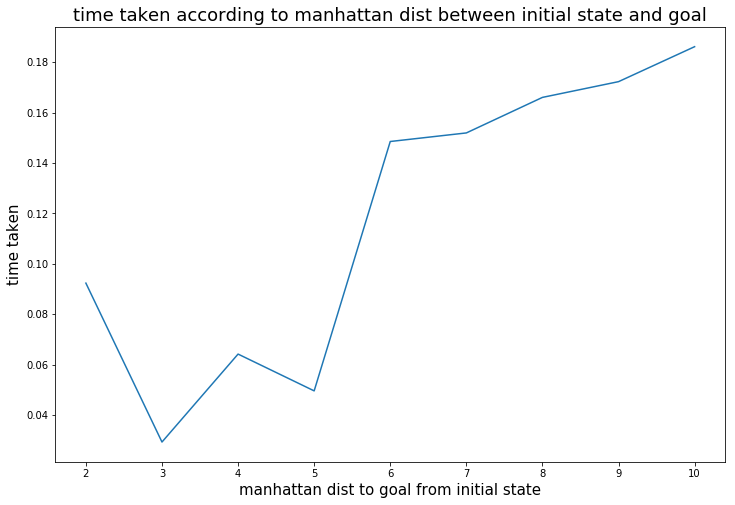

In [81]:
plt.figure(figsize=(12,8))
plt.title('time taken according to manhattan dist between initial state and goal', fontsize=18)
plt.xlabel('manhattan dist to goal from initial state', fontsize=15)
plt.ylabel('time taken', fontsize=15)
plt.plot(to_plot.keys(), to_plot.values())
plt.show()

## 위의 실험에서 도출할 수 있는 결론
1) start부터 goal까지 최적의 경로로 도달하게 안내하는 ${Q}$를 찾는 것은 start를 무엇으로 설정하느냐에 영향을 받지 않는다. 즉, start를 다르게 해도 SARSA는 답을 찾는다.  

2) start에 따라 학습되는 $Q$ table 값을 다르다. start가 (2,7), goal이 (3,7)인 경우 학습된 Q로는 $q(s=(3,0), a), \forall a$를 제대로 학습하지 않는다
    
3) 그러나 실제 훈련에 걸린 시간을 보면, start가 goal에서 멀수록(mahattan distance 기준) 훈련에 걸리는 시간이 길어짐을 알 수 있다